Removed First row from the PPG-BP dataset xlsx file
Converted new xlsx to CSV for faster execution
New CSV file named as SubjectData.csv
PPGBPDatabase folder contains all the ppg cycle of the subjects in TXT format

In [76]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics


from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

## Importing SubjectData CSV file using Pandas

In [77]:
SubjectData=pd.read_csv('SubjectData.csv')
target="Hypertension"
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.27,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.28,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.89,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.97,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.06,Prehypertension,NaN,NaN,NaN


### Data Cleaning
Label encoding - converting the labels into numerical format <br>
Such as <br>
Encoding NaN with 0 in Cerebral Infarction and 'cerebral infarction' as 1 <br>
0 = No Cerebral Infarction <br>
1 = Cerebral Infarction

In [78]:
label_encoder = preprocessing.LabelEncoder()
SubjectData.fillna(0)
SubjectData['cerebral infarction']= label_encoder.fit_transform(SubjectData['cerebral infarction'])
SubjectData['Hypertension']= label_encoder.fit_transform(SubjectData['Hypertension'])
SubjectData['Diabetes']= label_encoder.fit_transform(SubjectData['Diabetes'])
SubjectData['cerebrovascular disease']= label_encoder.fit_transform(SubjectData['cerebrovascular disease'])
SubjectData['Sex(M/F)']= label_encoder.fit_transform(SubjectData['Sex(M/F)'])

In [79]:
countCI=SubjectData[target].value_counts()
print('Total number of subjects :',countCI[1]+countCI[0])
print(f'Total number of subjects with {target}:',countCI[0])
print(f'Total number of subjects without {target}:',countCI[1])

Total number of subjects : 165
Total number of subjects with Hypertension: 80
Total number of subjects without Hypertension: 85


In [80]:
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,0,45,152,63,161,89,97,27.27,3,1,1,2
1,2,3,0,50,157,50,160,93,76,20.28,3,1,1,2
2,3,6,0,47,150,47,101,71,79,20.89,0,1,1,2
3,4,8,1,45,172,65,136,93,87,21.97,1,1,1,2
4,5,9,0,46,155,65,123,73,73,27.06,1,1,1,2


### Importing PPG Cycle of the Target Patients in a dictionary


In [81]:
baseurl='PPGBPDatabase/'
PPGCycle={}
for i in range(420):
    try:
        temp=[]
        for j in range(1,4):
            f=open(baseurl+f'{i}_{j}.txt','r')
            data=f.readline()
            data=data.split('\t')
            data=data[0:-1]
            data=list(map(int,list(map(float,data))))
            f.close()
            temp.append(data)  
        PPGCycle[str(i)]=temp
    except:
        continue

## Sample Ploting of PPG Cycle of Subject 2

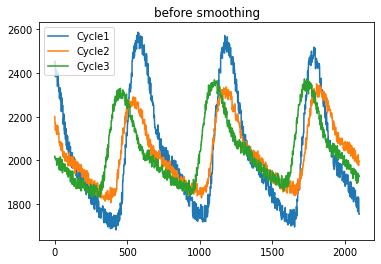

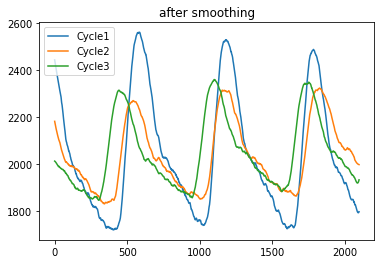

In [82]:
C1=PPGCycle['2'][0]
C2=PPGCycle['2'][1]
C3=PPGCycle['2'][2]
C1Sol=savgol_filter(C1,51,3)
C2Sol=savgol_filter(C2,51,3)
C3Sol=savgol_filter(C3,51,3)
plt.title("before smoothing")
plt.plot(C1,label='Cycle1')
plt.plot(C2,label='Cycle2')
plt.plot(C3,label='Cycle3')
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()
plt.plot(C1Sol,label='Cycle1')
plt.plot(C2Sol,label='Cycle2')
plt.plot(C3Sol,label='Cycle3')
plt.title("after smoothing")
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()

### Extracting Infromation from the PPGCycle

# Functions to calculate Featues and other values

In [83]:
def Kurt(x):
    size=len(x)
    deviationSq=[]
    deviationSq4=[]
    mean=sum(x)/size
    for i in x:
        deviationSq.append((i-mean)**2)
        deviationSq4.append((i-mean)**4)
    SecondMoment=sum(deviationSq)/size
    FourthMoment=sum(deviationSq4)/size
    Kurtosis=FourthMoment/(SecondMoment**2)
    return Kurtosis

def maxminslope(x):
    max=-math.inf
    min=math.inf
    size=len(x)
    for i in range(size-1):
        if x[i+1]-x[i]>max:
            max=x[i+1]-x[i]
        if x[i+1]-x[i]<min:
            min=x[i+1]-x[i]
    return max,min
def Conf(act,pred):
    size=len(act)
    act=list(map(int,act))
    pred=list(map(int,pred))
    TN=0
    FP=0
    FN=0
    TP=0
    for i in range(size):
        if(act[i]==0 and pred[i]==0):
            TN+=1
        elif(act[i]==0 and pred[i]==1):
            FP+=1
        elif(act[i]==1 and pred[i]==0):
            FN+=1
        elif(act[i]==1 and pred[i]==1):
            TP+=1
    print('TN:',TN)
    print('FP:',FP)
    print('FN:',FN)
    print('TP:',TP)
    print('Precision:',TP/(TP+FP))
    print('Recall:',TP/(TP+FN))
    print('F1 Score:',2*TP/(2*TP+FP+FN))
    sns.heatmap([[TN,FP],[FN,TP]],annot=True,fmt='d')
    return 
        
def Skewness(x):
    size=len(x)
    mean=sum(x)/size
    deviation=[]
    deviationSq=[]
    StandardDeviation=0
    for i in x:
        deviation.append((i-mean))
        deviationSq.append((i-mean)**2)
        StandardDeviation+=(i-mean)**2

    StandardDeviation=(StandardDeviation/size)**0.5
    Skewness=0
    for i in deviation:
        Skewness+=(i/StandardDeviation)**3
    Skewness=Skewness*size/(size-1)/(size-2)
    return Skewness


In [84]:
extractPPGCycle={}
CMean=[[],[],[],[]]
CKurtosis=[[],[],[],[]]
CSkewness=[[],[],[],[]]
CMaxSlope=[[],[],[],[]]
CMinSlope=[[],[],[],[]]
for i in PPGCycle.keys():
    temp=[]
    alldata=[]
    for j in range(3):
        data=PPGCycle[i][j]
        alldata+=data
        tempdict={}
        tempdict['Mean']=np.mean(data)
        # tempdict['Kurtosis']=kurtosis(data, fisher=False)
        tempdict['Kurtosis']=Kurt(data)
        tempdict['Skewness']=Skewness(data)
        tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(data)
        CMean[j].append(tempdict['Mean'])
        CKurtosis[j].append(tempdict['Kurtosis'])
        CSkewness[j].append(tempdict['Skewness'])
        CMaxSlope[j].append(tempdict['MaxSlope'])
        CMinSlope[j].append(tempdict['MinSlope'])
        temp.append(tempdict)
    tempdict={}
    tempdict['Mean']=np.mean(alldata)
    tempdict['Kurtosis']=Kurt(alldata)
    tempdict['Skewness']=Skewness(alldata)
    tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(alldata)
    CMean[3].append(tempdict['Mean'])
    CKurtosis[3].append(tempdict['Kurtosis'])
    CSkewness[3].append(tempdict['Skewness'])
    CMaxSlope[3].append(tempdict['MaxSlope'])
    CMinSlope[3].append(tempdict['MinSlope'])
    temp.append(tempdict)
    extractPPGCycle[i]=temp

### Inserting Extracted Data into the SubjectData

In [85]:
SubjectData['C1-Mean']=CMean[0]
SubjectData['C1-Kurtosis']=CKurtosis[0]
SubjectData['C1-Skewness']=CSkewness[0]
SubjectData['C1-MaxSlope']=CMaxSlope[0]
SubjectData['C1-MinSlope']=CMinSlope[0]
SubjectData['C2-Mean']=CMean[1]
SubjectData['C2-Kurtosis']=CKurtosis[1]
SubjectData['C2-Skewness']=CSkewness[1]
SubjectData['C2-MaxSlope']=CMaxSlope[1]
SubjectData['C2-MinSlope']=CMinSlope[1]
SubjectData['C3-Mean']=CMean[2]
SubjectData['C3-Kurtosis']=CKurtosis[2]
SubjectData['C3-Skewness']=CSkewness[2]
SubjectData['C3-MaxSlope']=CMaxSlope[2]
SubjectData['C3-MinSlope']=CMinSlope[2]
SubjectData['C-Mean']=CMean[3]
SubjectData['C-Kurtosis']=CKurtosis[3]
SubjectData['C-Skewness']=CSkewness[3]
SubjectData['C-MaxSlope']=CMaxSlope[3]
SubjectData['C-MinSlope']=CMinSlope[3]
#Min Max Kurtosis and Skewness Mean
#Max slope of the line


In [86]:
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,C3-Mean,C3-Kurtosis,C3-Skewness,C3-MaxSlope,C3-MinSlope,C-Mean,C-Kurtosis,C-Skewness,C-MaxSlope,C-MinSlope
0,1,2,0,45,152,63,161,89,97,27.27,...,2045.224762,2.223780,0.667033,65,-66,2038.692381,2.778840,0.662604,447,-87
1,2,3,0,50,157,50,160,93,76,20.28,...,2007.157143,1.883882,0.422054,49,-48,2004.373968,2.013632,0.449374,58,-60
2,3,6,0,47,150,47,101,71,79,20.89,...,2020.478571,1.817075,0.494501,46,-48,2013.143492,2.355045,0.504403,68,-135
3,4,8,1,45,172,65,136,93,87,21.97,...,2021.939048,2.005190,0.504060,43,-49,2023.992222,2.155941,0.546420,125,-53
4,5,9,0,46,155,65,123,73,73,27.06,...,2010.850952,2.008548,0.474505,64,-54,2011.915079,2.074053,0.354313,64,-80


### Plotting Heat Map

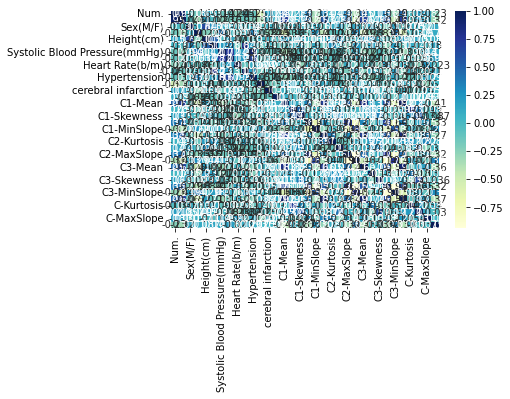

In [87]:
dataplot=sns.heatmap(SubjectData.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Create Training and Test Sets

In [88]:
# X = SubjectData.iloc[:, :-1]
X = SubjectData.drop([
    'subject_ID',
    target,'Height(cm)','Weight(kg)','Age(year)',
    # 'C-Mean','C-Kurtosis','C-Skewness','C-MaxSlope','C-MinSlope',
    # 'C1-Mean','C1-Kurtosis','C1-Skewness','C1-MaxSlope','C1-MinSlope',
    # 'C2-Mean','C2-Kurtosis','C2-Skewness','C2-MaxSlope','C2-MinSlope',
    # 'C3-Mean','C3-Kurtosis','C3-Skewness','C3-MaxSlope','C3-MinSlope',
    ],axis=1)
y = SubjectData[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# X_train=X
# y_train=y

## Data Representation Function


In [89]:
def ClassificationMain(model,modelname,X_test=X_test,y_test=y_test):
    y_pred=model.predict(X_test)
    print(f"For {modelname}")
    scores_accuracy = cross_val_score(model, X, y, cv=20,scoring='accuracy')
    scores_roc_auc = cross_val_score(model, X, y, cv=20,scoring='roc_auc')
    print(classification_report(y_test, y_pred))
    print (f'Accuracy: {scores_accuracy.mean():.2f} +/- {scores_accuracy.std() * 2:.2f}')
    print (f'ROC AUC: {scores_roc_auc.mean():.2f} +/- {scores_roc_auc.std() * 2:.2f}')

    print()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # with labels
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {modelname}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return "Done"





def test_train_accuracy(model,modelname,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    print(f'Accuracy of {modelname} classifier on training set: {model.score(X_train, y_train):.2f}')
    print(f'Accuracy of {modelname} classifier on test set: {model.score(X_test, y_test):.2f}')



In [90]:

smote = SMOTE(random_state = 2)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train.ravel())

Accuracy of Random Forest Normal classifier on training set: 1.00
Accuracy of Random Forest Normal classifier on test set: 0.91
Accuracy of Random Forest Over classifier on training set: 1.00
Accuracy of Random Forest Over classifier on test set: 0.91
Random Forest
For Random Forest Normal
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.92      1.00      0.96        11
           2       0.75      0.75      0.75         4
           3       1.00      0.50      0.67         2

    accuracy                           0.91        22
   macro avg       0.92      0.81      0.84        22
weighted avg       0.91      0.91      0.90        22

Accuracy: 0.90 +/- 0.13
ROC AUC: nan +/- nan



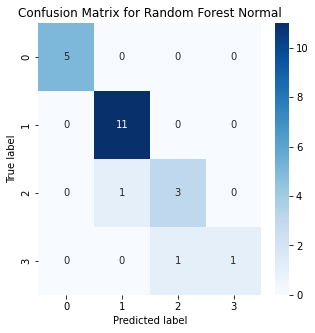

For Random Forest Over
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.92      1.00      0.96        11
           2       0.75      0.75      0.75         4
           3       1.00      0.50      0.67         2

    accuracy                           0.91        22
   macro avg       0.92      0.81      0.84        22
weighted avg       0.91      0.91      0.90        22

Accuracy: 0.90 +/- 0.13
ROC AUC: nan +/- nan



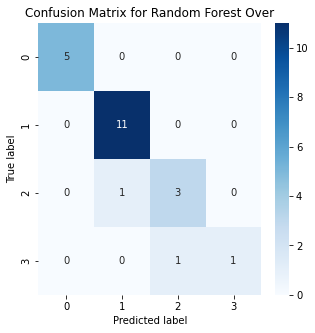

'Done'

In [91]:
# Random Forest

RFNormal = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train, y_train)
RFOver = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train_over, y_train_over)

test_train_accuracy(RFNormal,'Random Forest Normal')
test_train_accuracy(RFOver,'Random Forest Over')
print("Random Forest")
ClassificationMain(RFNormal,'Random Forest Normal')
ClassificationMain(RFOver,'Random Forest Over')

Accuracy of MLP Normal classifier on training set: 0.39
Accuracy of MLP Normal classifier on test set: 0.32
Accuracy of MLP Over classifier on training set: 0.52
Accuracy of MLP Over classifier on test set: 0.36
MLP
For MLP Normal
              precision    recall  f1-score   support

           0       0.27      0.80      0.40         5
           1       0.43      0.27      0.33        11
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2

    accuracy                           0.32        22
   macro avg       0.17      0.27      0.18        22
weighted avg       0.27      0.32      0.26        22

Accuracy: 0.40 +/- 0.21
ROC AUC: nan +/- nan



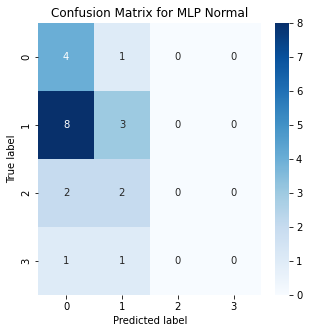

For MLP Over
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.27      0.40        11
           2       0.20      0.50      0.29         4
           3       0.00      0.00      0.00         2

    accuracy                           0.36        22
   macro avg       0.39      0.34      0.32        22
weighted avg       0.55      0.36      0.39        22

Accuracy: 0.40 +/- 0.21
ROC AUC: nan +/- nan



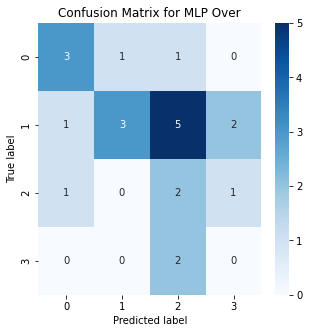

'Done'

In [92]:

MLPNormal = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
MLPOver = MLPClassifier(random_state=1, max_iter=300).fit(X_train_over, y_train_over)

test_train_accuracy(MLPNormal,'MLP Normal')
test_train_accuracy(MLPOver,'MLP Over')
print("MLP")
ClassificationMain(MLPNormal,'MLP Normal')
ClassificationMain(MLPOver,'MLP Over')

Accuracy of XGB Normal classifier on training set: 1.00
Accuracy of XGB Normal classifier on test set: 1.00
Accuracy of XGB Over classifier on training set: 1.00
Accuracy of XGB Over classifier on test set: 1.00
XGBoost
For XGB Normal
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Accuracy: 1.00 +/- 0.04
ROC AUC: nan +/- nan



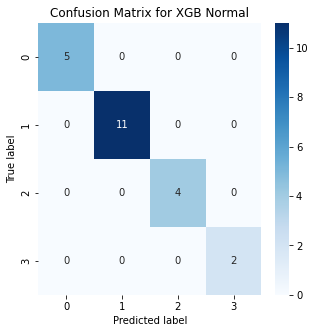

For XGB Over
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Accuracy: 1.00 +/- 0.04
ROC AUC: nan +/- nan



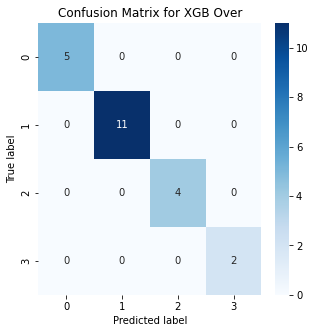

'Done'

In [93]:

xgbnormal = xgb.XGBClassifier(random_state=1).fit(X_train, y_train)
xgbover = xgb.XGBClassifier(random_state=1).fit(X_train_over, y_train_over)

test_train_accuracy(xgbnormal,'XGB Normal')
test_train_accuracy(xgbover,'XGB Over')
print("XGBoost")
ClassificationMain(xgbnormal,'XGB Normal')
ClassificationMain(xgbover,'XGB Over')


Accuracy of Gradient Boosting Normal classifier on training set: 1.00
Accuracy of Gradient Boosting Normal classifier on test set: 1.00
Accuracy of Gradient Boosting Over classifier on training set: 1.00
Accuracy of Gradient Boosting Over classifier on test set: 1.00
Gradient Boosting
For Gradient Boosting Normal
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Accuracy: 1.00 +/- 0.00
ROC AUC: nan +/- nan



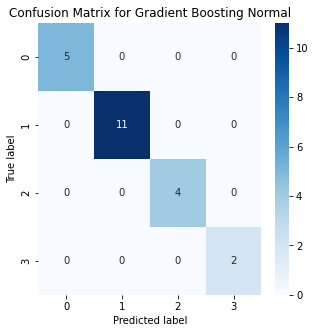

For Gradient Boosting Over
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Accuracy: 1.00 +/- 0.00
ROC AUC: nan +/- nan



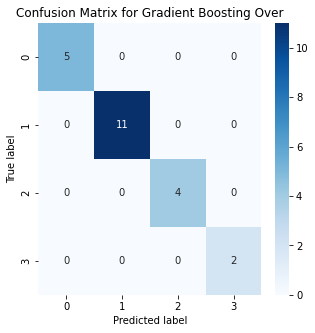

'Done'

In [94]:
GBNormal= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
GBOver= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_over, y_train_over)

test_train_accuracy(GBNormal,'Gradient Boosting Normal')
test_train_accuracy(GBOver,'Gradient Boosting Over')
print("Gradient Boosting")
ClassificationMain(GBNormal,'Gradient Boosting Normal')
ClassificationMain(GBOver,'Gradient Boosting Over')